 # High-Risk Pregnancy Prediction Pipeline
 Hybrid ML + Feature Selection + Hyperparameter Optimization + XAI

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
)
from sklearn.feature_selection import RFE, chi2, mutual_info_classif
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from xgboost import XGBClassifier

import shap
import random


 ## 1. Load Dataset

In [3]:
df = pd.read_csv("Maternal Health Risk Data Set.csv")
df = df.dropna(subset=["RiskLevel"])

target = "RiskLevel"
X = df.drop(columns=[target])
y = df[target]

# encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Target mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

Target mapping: {'high risk': np.int64(0), 'low risk': np.int64(1), 'mid risk': np.int64(2)}


 ## 2. Preprocessing

In [4]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder="drop"
)

 ## 3. Baseline Models

In [5]:
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "RF": RandomForestClassifier(random_state=42),
    "XGB": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
    "GB": GradientBoostingClassifier()
}

results = {}
probas={}
for name, model in models.items():
    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ml_proba = clf.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    probas[name] = ml_proba

    print(f"{name} Accuracy: {acc:.4f}")
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, digits=4))
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\nOverall Model Performance:")
print(results_df)

LogReg Accuracy: 0.6207
Classification Report for LogReg:

              precision    recall  f1-score   support

           0     0.7818    0.7818    0.7818        55
           1     0.5905    0.7654    0.6667        81
           2     0.4884    0.3134    0.3818        67

    accuracy                         0.6207       203
   macro avg     0.6202    0.6202    0.6101       203
weighted avg     0.6086    0.6207    0.6039       203

RF Accuracy: 0.8621
Classification Report for RF:

              precision    recall  f1-score   support

           0     0.9630    0.9455    0.9541        55
           1     0.9028    0.8025    0.8497        81
           2     0.7532    0.8657    0.8056        67

    accuracy                         0.8621       203
   macro avg     0.8730    0.8712    0.8698       203
weighted avg     0.8697    0.8621    0.8634       203

XGB Accuracy: 0.8621
Classification Report for XGB:

              precision    recall  f1-score   support

           0     0.9

## Applying Clinical Thresholds

In [6]:
def clinical_rules(X, classes):
    proba = np.zeros((len(X), len(classes)))
    idx_low = np.where(classes == 0)[0][0] if 0 in classes else None
    idx_high = np.where(classes == 1)[0][0] if 1 in classes else None

    for i in range(len(X)):
        sbp = X.iloc[i]["Systolic BP"]
        dbp = X.iloc[i]["Diastolic"]
        bs = X.iloc[i]["BS"]
        temp = X.iloc[i]["Body Temp"]
        bmi = X.iloc[i]["BMI"]
        hr = X.iloc[i].get("HR", np.nan)     # optional
        preD = X.iloc[i].get("PreDiabetes", 0)
        gdm = X.iloc[i].get("GDM", 0)
        prev = X.iloc[i].get("PrevComplications", 0)
        mh = X.iloc[i].get("MH", 0)

        high_flags = 0
        moderate_flags = 0

        # High-risk thresholds
        if pd.notna(sbp) and sbp >= 140: high_flags += 1
        if pd.notna(dbp) and dbp >= 90:  high_flags += 1
        if pd.notna(bs) and bs >= 7.8:   high_flags += 1
        if pd.notna(bmi) and bmi >= 35:  high_flags += 1
        if pd.notna(temp) and temp >= 100.4: high_flags += 1
        if pd.notna(hr) and (hr >= 110 or hr <= 50): high_flags += 1
        if preD == 1 or gdm == 1: high_flags += 1
        if prev == 1: high_flags += 1

        # Moderate thresholds
        if pd.notna(sbp) and 130 <= sbp < 140: moderate_flags += 1
        if pd.notna(dbp) and 85 <= dbp < 90:   moderate_flags += 1
        if pd.notna(bs) and 6.7 <= bs < 7.8:   moderate_flags += 1
        if pd.notna(bmi) and 30 <= bmi < 35:   moderate_flags += 1
        if mh == 1: moderate_flags += 1

        
        base = np.ones(len(classes), dtype=float) / len(classes)

        if high_flags >= 1 and idx_high is not None:
            base *= 0.2
            base[idx_high] = 0.8
        elif moderate_flags >= 2 and idx_high is not None and idx_low is not None:
            base *= 0.2
            base[idx_high] = 0.6
            base[idx_low]  = 0.2
        elif idx_low is not None:
            base *= 0.2
            base[idx_low] = 0.8

        proba[i] = base

    return proba



In [7]:
def clinical_rules(df_part, classes):

    proba = np.zeros((len(df_part), len(classes)))

    for i in range(len(df_part)):
        row = df_part.iloc[i]

        sbp  = row.get("SystolicBP", np.nan)
        dbp  = row.get("DiastolicBP", np.nan)
        bs   = row.get("BS", np.nan)
        temp = row.get("BodyTemp", np.nan)
        bmi  = row.get("BMI", np.nan)
        hr   = row.get("HeartRate", np.nan)

        # Optional ones (set to 0 if missing)
        preD = row.get("PreDiabetes", 0)
        gdm  = row.get("GDM", 0)
        prev = row.get("PrevComplications", 0)
        mh   = row.get("MH", 0)

        high_flags = 0
        moderate_flags = 0

        # HIGH RISK THRESHOLDS
        if pd.notna(sbp) and sbp >= 140: high_flags += 1
        if pd.notna(dbp) and dbp >= 90:  high_flags += 1
        if pd.notna(bs) and bs >= 7.8:   high_flags += 1
        if pd.notna(bmi) and bmi >= 35:  high_flags += 1
        if pd.notna(temp) and temp >= 100.4: high_flags += 1
        if pd.notna(hr) and (hr >= 110 or hr <= 50): high_flags += 1
        if preD == 1 or gdm == 1: high_flags += 1
        if prev == 1: high_flags += 1

        # MODERATE RISK THRESHOLDS
        if pd.notna(sbp) and 130 <= sbp < 140: moderate_flags += 1
        if pd.notna(dbp) and 85 <= dbp < 90:   moderate_flags += 1
        if pd.notna(bs) and 6.7 <= bs < 7.8:   moderate_flags += 1
        if pd.notna(bmi) and 30 <= bmi < 35:   moderate_flags += 1
        if mh == 1: moderate_flags += 1

        base = np.ones(len(classes)) / len(classes)

        idx_high = list(classes).index('high risk')
        idx_mid  = list(classes).index('mid risk')
        idx_low  = list(classes).index('low risk')

        if high_flags >= 1:
            base *= 0.2
            base[idx_high] = 0.8

        elif moderate_flags >= 2:
            base *= 0.2
            base[idx_mid] = 0.6
            base[idx_low] = 0.2

        else:
            base *= 0.2
            base[idx_low] = 0.8

        proba[i] = base

    return proba


 ## 4. Stacking & Voting (Hybrid Models)

In [8]:
estimators = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(eval_metric="logloss", use_label_encoder=False))
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)

voting = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

hybrid_models = {"Stacking": stacking, "Voting": voting}

for name, model in hybrid_models.items():
    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Stacking Accuracy: 0.8768
Voting Accuracy: 0.8768


 ## 5. Feature Selection 

### XG Boost

In [9]:
def xgb_importance(X, y):
    model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
    model.fit(X, y)
    return model.feature_importances_

### Recursive Feature Elimination

In [10]:

# -------------------------------
# 2. RFE Wrapper
# -------------------------------
def rfe_selection(X, y, n_features=10):
    base = RandomForestClassifier(random_state=42)
    selector = RFE(base, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return selector.support_, selector.ranking_


### Genetic Algorithm

In [11]:

def ga_feature_selection(X, y, generations=10, population_size=8):
    def fitness(features):
        model = RandomForestClassifier(random_state=42)
        model.fit(X.iloc[:, features], y)
        return accuracy_score(y, model.predict(X.iloc[:, features]))

    n_features = X.shape[1]
    population = [random.sample(range(n_features), n_features//2) for _ in range(population_size)]

    for _ in range(generations):
        scores = [fitness(ind) for ind in population]
        sorted_idx = np.argsort(scores)[::-1]
        survivors = [population[i] for i in sorted_idx[:population_size//2]]
        new_pop = survivors.copy()
        while len(new_pop) < population_size:
            p1, p2 = random.sample(survivors, 2)
            child = list(set(p1[:len(p1)//2] + p2[len(p2)//2:]))
            if random.random() < 0.2:
                child.append(random.randint(0, n_features-1))
            new_pop.append(list(set(child)))
        population = new_pop

    best = max(population, key=fitness)
    return best


### Particle Swarm Optimization

In [12]:

def pso_feature_selection(X, y, n_particles=10, iterations=10):
    n_features = X.shape[1]
    particles = np.random.randint(0, 2, size=(n_particles, n_features))
    velocities = np.random.rand(n_particles, n_features)
    personal_best = particles.copy()
    global_best = particles[0].copy()

    def fitness(mask):
        cols = np.where(mask == 1)[0]
        if len(cols) == 0:
            return 0
        model = RandomForestClassifier(random_state=42)
        model.fit(X.iloc[:, cols], y)
        return accuracy_score(y, model.predict(X.iloc[:, cols]))

    best_score = 0
    for i in range(n_particles):
        score = fitness(particles[i])
        if score > best_score:
            best_score = score
            global_best = particles[i].copy()

    for _ in range(iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = velocities[i] + r1*(personal_best[i]-particles[i]) + r2*(global_best-particles[i])
            particles[i] = (np.random.rand(n_features) < 1/(1+np.exp(-velocities[i]))).astype(int)

            score = fitness(particles[i])
            if score > fitness(personal_best[i]):
                personal_best[i] = particles[i].copy()
            if score > best_score:
                best_score = score
                global_best = particles[i].copy()

    return np.where(global_best == 1)[0]


### Chi-Square

In [13]:


def chi2_selection(X, y):
    X_filled = SimpleImputer(strategy="median").fit_transform(X)
    # MinMax scaling to ensure non-negative
    X_scaled = MinMaxScaler().fit_transform(X_filled)
    scores, _ = chi2(X_scaled, y)
    return scores

### Mutual Imformation

In [14]:
def mi_selection(X, y):
    
    X_filled = SimpleImputer(strategy="median").fit_transform(X)
    X_scaled = MinMaxScaler().fit_transform(X_filled)
    scores = mutual_info_classif(X_scaled, y, random_state=42)
    return scores


### SHAP

In [15]:
def shap_importance(X, y):
    model = XGBClassifier(
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    )
    model.fit(X, y)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # CASE 1: Multi-class, shap_values is a list: [array_for_class0, array_for_class1, ...]
    if isinstance(shap_values, list):
        # Each element: (n_samples, n_features)
        classwise = [np.abs(vals).mean(axis=0) for vals in shap_values]  # list of (n_features,)
        imp = np.mean(classwise, axis=0)  # (n_features,)
        return np.array(imp).flatten()

    # CASE 2: shap_values is a numpy array
    arr = np.array(shap_values)

    # If shape is (n_samples, n_features, n_classes)
    if arr.ndim == 3:
        # Mean over samples and classes → per-feature importance
        imp = np.abs(arr).mean(axis=(0, 2))  # → (n_features,)
        return imp.flatten()

    # If shape is (n_samples, n_features)
    if arr.ndim == 2:
        imp = np.abs(arr).mean(axis=0)  # → (n_features,)
        return imp.flatten()

    # Fallback: flatten whatever is left (shouldn't really happen)
    return np.abs(arr).flatten()[: X.shape[1]]


### Permutation Importance

In [16]:

def permutation_importance_scores(X, y):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    return result.importances_mean

## Output of all Feature Importance

In [17]:

def run_all_feature_selection(X, y):
    results = pd.DataFrame({"Feature": X.columns})

    # 1. XGBoost Embedded
    results["XGB"] = xgb_importance(X, y)

    # 2. RFE
    support, ranking = rfe_selection(X, y, n_features=10)
    results["RFE_Ranking"] = ranking
    results["RFE_Selected"] = support

    # 3. GA
    ga_features = ga_feature_selection(X, y)
    results["GA_Selected"] = results.index.isin(ga_features).astype(int)

    # 4. PSO
    pso_features = pso_feature_selection(X, y)
    results["PSO_Selected"] = results.index.isin(pso_features).astype(int)

    # 5. Chi-Square
    results["Chi2"] = chi2_selection(X, y)

    # 6. Mutual Information
    results["MI"] = mi_selection(X, y)

    # 7. SHAP
    results["SHAP"] = shap_importance(X, y)

    # 8. Permutation Importance
    results["Permutation"] = permutation_importance_scores(X, y)

    return results


feature_results = run_all_feature_selection(X_train, y_train)

# Show all results
print("\n=== Feature Selection Results ===\n")
print(feature_results)

# If you want sorted by any method (e.g. SHAP):
print("\n=== Top Features by SHAP ===\n")
print(feature_results.sort_values("SHAP", ascending=False).head(10))


=== Feature Selection Results ===

       Feature       XGB  RFE_Ranking  RFE_Selected  GA_Selected  \
0          Age  0.084642            1          True            1   
1   SystolicBP  0.341086            1          True            0   
2  DiastolicBP  0.080803            1          True            1   
3           BS  0.237421            1          True            1   
4     BodyTemp  0.187726            1          True            1   
5    HeartRate  0.068321            1          True            1   

   PSO_Selected       Chi2        MI      SHAP  Permutation  
0             1   9.679113  0.213656  0.531316     0.109494  
1             0  12.490925  0.264673  0.714716     0.183231  
2             1  17.743344  0.161701  0.277989     0.052528  
3             1  91.528975  0.302780  1.258070     0.345253  
4             1  14.924520  0.064790  0.540548     0.096547  
5             1   0.416943  0.147636  0.362844     0.063502  

=== Top Features by SHAP ===

       Feature       X

 ## 6. Hyperparameter Optimization 

### Bayesian Search

In [18]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier

# Define search space
search_space = {
    "n_estimators": Integer(50, 300),
    "max_depth": Integer(3, 15),
    "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "subsample": Real(0.5, 1.0)
}

# Initialize BayesSearchCV
opt_bayes = BayesSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    search_spaces=search_space,
    n_iter=30,          # number of parameter settings to try
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

opt_bayes.fit(X_train, y_train)

print("Best params (Bayesian):", opt_bayes.best_params_)
print("Best CV score (Bayesian):", opt_bayes.best_score_)
print("Test Accuracy (Bayesian):", opt_bayes.score(X_test, y_test))


Best params (Bayesian): OrderedDict([('learning_rate', 0.06348516039427839), ('max_depth', 14), ('n_estimators', 174), ('subsample', 0.9188282185302634)])
Best CV score (Bayesian): 0.831098992653185
Test Accuracy (Bayesian): 0.8571428571428571


 ## 7. Explainable AI (XAI)

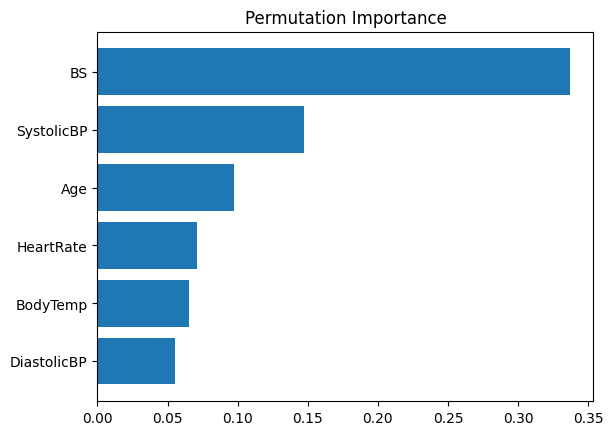

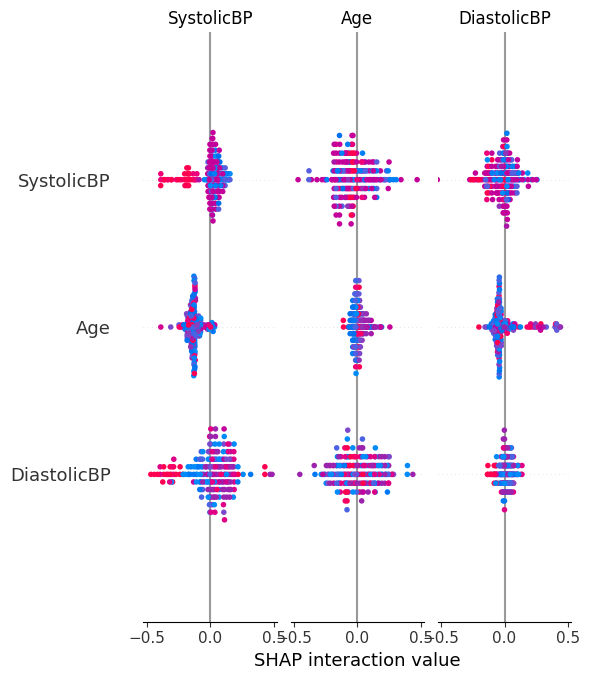

In [19]:
final_model = Pipeline(steps=[("preprocess", preprocess), ("model", RandomForestClassifier(random_state=42))])
final_model.fit(X_train, y_train)

# Permutation Importance
perm = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), perm.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(numeric_features)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

# SHAP values
explainer = shap.TreeExplainer(final_model.named_steps["model"])
X_transformed = preprocess.transform(X_test)
shap_values = explainer.shap_values(X_transformed)

shap.summary_plot(shap_values, X_transformed, feature_names=numeric_features)

In [20]:
import joblib
joblib.dump(voting, "soft_voting_model.pkl")


['soft_voting_model.pkl']

In [23]:
import joblib

# -----------------------------------
# 1. Define the base estimators
# -----------------------------------
estimators = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(eval_metric="logloss", use_label_encoder=False))
]

# -----------------------------------
# 2. Define Soft Voting Ensemble
# -----------------------------------
voting = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

# -----------------------------------
# 3. Create the FULL PIPELINE
# -----------------------------------
clf = Pipeline(steps=[
    ("preprocess", preprocess),   # your preprocessing transformer
    ("model", voting)             # your ensemble model
])

# -----------------------------------
# 4. Train the Pipeline
# -----------------------------------
clf.fit(X_train, y_train)

# -----------------------------------
# 5. Save the trained pipeline
# -----------------------------------
joblib.dump(clf, "maternal_risk_pipeline.pkl")

print("Model saved as maternal_risk_pipeline.pkl")


Model saved as maternal_risk_pipeline.pkl
